<a target="_blank" href="https://colab.research.google.com/github/alejandrogtz/cccs630-fall2023/blob/main/module04/agent-based_applications.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Applications of Agent-Based Simulations

## Introduction

In this module, we will examine various applications of agent-based simulations and analyze a simulation to explore how traffic jams are formed.

Agent-based simulations allow testing different changes to the agents, scenarios, and conditions of a system. In the case of transportation systems, it is possible to study changes to the roads, drivers, traffic laws, and roadblocks, for example. Depending on the objective of a study, these changes can then be quantified in terms of CO2 emissions, transportation time, number of accidents, maximum number of vehicles, etc.

In preparation for the interaction part, please read the following Wikipedia entry about one of the longest traffic jams ever recorded.

https://en.wikipedia.org/wiki/China_National_Highway_110_traffic_jam

## Concepts

You will find a list of important concepts we will review in the module below.

- Assumptions
- Traffic jams
- Transportation systems
- Random noise

## Interaction

There are many applications of agent-based simulations. Some of these include:

- Spread of infectious diseases
- Behaviour of economic systems
- Behaviour of transportation systems

### Traffic Jams

In this interaction, we will use an agent-based simulation to study traffic jams. 

The objective of the simulation is to 

Test if traffic jams can emerge from normal conditions.

In the previous modules, the agents ocupied one discrete squares in a a 1D (array) or 2D grid (checkboard). In this modules 

Until now in the course, the our agents have functioned in 1D or 2D grid spaces, but we can make use of other structures like networks, ... TODO. The simulation below assumes cars move in a continuous one-dimensional circular space 

The class Driver defines the operation of the agent. 

The agent Driver operates in an object named Highway. The Highway is a .... and has a circular shape. In the simulation, the number of drivers doesn't change.


The driver only needs to determine its acceleration. The maximum acceleration is 1 and the minimum is -10.

Random noice is added to the vehicle speed. This noice represents the imperfection in the conditions (distracted driver, mechanical problems, etc.) A random noise of..... 

Limitations

- Single line highway.
- Vehicles can't be passed.
- Vehicles can only go forward.
- Vehicles have a maximum speed of 40 miles/hr (64.37 km/hr).
- Vehicles start equally spaced.
- Drivers will have slight different speeds because of the random noise.
- Collisions (indicated with a triangle in the simulation) cause vehicles to stop.

Squares indicate the position of the drivers.
Triangles indicate the places where one driver has to break to avoid a collision.

- Driver accelerate to the maximum rate. THIS IS NOT CORRECT

The code below simulates a highway, and n number of drivers. The code is based on the work of Allen Downey as it appears on the book Think Complexity, 2nd edition (https://thinkcomplex.com) and published under MIT License (http://opensource.org/licenses/MIT).

Instructions

- Simulate the system assuming a low number of vehicles (<=10 vehicles) and no random noise (eps = 0) and document your findings.
- Simulate the system assuming a intermediate number of vehicles (<=25 vehicles) and a random noise (eps = 0.02) and document your findings.

To confirm. Acceleration is speed plus a certain amount.

Chooses acceleration based on distance. TODO
        
        dist: distance from the car in front
        
        returns: acceleration
        
Add and remove drivers. Duration of the drivers in the highway.
You could simulate a linear highway with some roadblocks.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
!git clone https://github.com/alejandrogtz/cccs630-fall2023

In [ ]:
from importlib.machinery import SourceFileLoader

In [ ]:
utils = SourceFileLoader('utils', '/content/cccs630-fall2023/module04/utils.py').load_module()

In [ ]:
Cell2D = SourceFileLoader('Cell2D', '/content/cccs630-fall2023/module04/Cell2D.py').load_module()

In [ ]:
from utils import decorate, savefig

In [ ]:
from Cell2D import Cell2D

In [179]:
from utils import decorate, savefig
from Cell2D import Cell2D

In [180]:
np.random.seed(1) # Sets the random values

In [181]:
class Driver:
    
    def __init__(self, loc, driver_id, speed=4):
        self.start = loc
        self.loc = loc # Position on track, in miles.
        self.speed = speed # Speed in miles per hour.
        self.driver_id = driver_id
        
    def choose_acceleration(self, dist):
        return (1) # Increases speed by 1 mile/hr.
    
    def read_driver_id(self):
        return self.driver_id
    
    def set_odometer(self):
        self.start = self.loc
        
    def read_odometer(self):
        return self.loc - self.start
    
    def read_speedometer(self):
        return self.speed

In [182]:
class Highway(Cell2D):
    
    max_acc = 1
    min_acc = -10
    speed_limit = 40
    driver_id_log = []
    location_log = []
    speed_log = []
    crash_log = []
    
    def __init__(self, n=10, length=1000, eps=0, constructor=Driver):
        #n: number of drivers
        #constructor: function used to instantiate drivers

        self.length = length # Length of the track.
        self.eps = eps # Variability in speed.
        self.crashes = 0

        locs = np.linspace(0, length, n, endpoint=False) # Evenly spaced numbers over a specified interval.
         
        self.drivers = []
        driver_id = 0
        for loc in locs:
            # Creates the drivers.
            self.drivers.append(constructor(loc,driver_id))
            driver_id += 1    
    
        # And link them up.
        for i in range(n):
            j = (i+1) % n
            self.drivers[i].next = self.drivers[j]
            
    def step(self):
        # Perform one time step.
        for driver in self.drivers:
            self.move(driver)
    
    # Updates `driver`
    def move(self, driver): 
        
        dist = self.distance(driver) # Get the distance to the next driver.
        acc = driver.choose_acceleration(dist) # Let the driver choose the acceleration.
        acc = min(acc, self.max_acc)
        acc = max(acc, self.min_acc)
        speed = driver.speed + acc
        
        # Add random noise to speed.
        speed *= np.random.uniform(1-self.eps, 1+self.eps)
        
        # Keep it nonnegative and under the speed limit.
        speed = max(speed, 0)
        speed = min(speed, self.speed_limit)
        
        # If current speed would collide with next driver, stop.
        crash = 0
        if speed > dist:
            speed = 0
            crash = 1
            self.crashes += 1
        
        # Update speed and loc
        driver.speed = speed
        driver.loc += speed
    
        self.driver_id_log.append(driver.driver_id)
        self.location_log.append(driver.loc)
        self.speed_log.append(driver.speed)
        self.crash_log.append(crash)
            
    # Distance from `driver` to next driver.
    def distance(self, driver):
      
        dist = driver.next.loc - driver.loc
        # Fix wraparound
        if dist < 0:
            dist += self.length
        
        return dist
    
    def set_odometers(self):
        return [driver.set_odometer()
                for driver in self.drivers] 
    
    def read_odometers(self):
        return np.mean([driver.read_odometer()
                        for driver in self.drivers])
    
    # Draws the drivers and shows collisions.
    def draw(self):
        
        drivers = self.drivers
        xs, ys = self.get_coords(drivers)
        plt.plot(xs, ys, 'bs', markersize=10, alpha=0.7)
        
        stopped = [driver for driver in self.drivers 
                  if driver.speed==0]
        xs, ys = self.get_coords(stopped, r=0.8)
        plt.plot(xs, ys, 'r^', markersize=12, alpha=0.7)
        
        plt.axis('off')
        plt.axis('equal')
        plt.xlim([-1.05, 1.05])
        plt.ylim([-1.05, 1.05])

    # Gets the coordinates of the drivers. Transforms from (row, col) to (x, y). 
    def get_coords(self, drivers, r=1):
        # r: radius of the circle
        
        locs = np.array([driver.loc for driver in drivers])
        locs *= 2 * np.pi / self.length
        xs = r * np.cos(locs)
        ys = r * np.sin(locs)
        return xs, ys # returns tuple of sequences, (xs, ys)
    
    # Sends the simulation data to an Excel file.
    def export_log(self): 
        log = {
                'Driver_ID':self.driver_id_log,
                'Speed' :self.speed_log,
                'Location':self.location_log,
                'Crash':self.crash_log,
                }
        df = pd.DataFrame(log)
        df.to_excel('log.xlsx', index=True, header=True)

In [183]:
# Function to explore the relationship between eps and average speed.
def run_simulation(eps, constructor=Driver, iters=100):
    res = []
    for n in range(5, 100, 5): # range function = range(start, stop, step) 
        
        highway = Highway(n, eps=eps, constructor=constructor)
        for i in range(iters):
            highway.step()

        highway.set_odometers()
        for i in range(iters):
            highway.step()

        res.append((n, highway.read_odometers() / iters))
    
    return np.transpose(res)

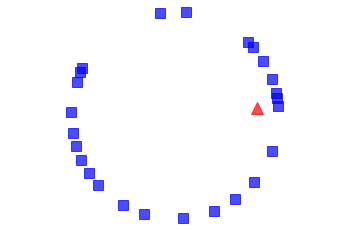

In [184]:
# Run the simulation.
highway = Highway(25, eps=0.01) # The first parameter is the number of drivers; the second is the amount of random noise.
# Create the animation.
highway.animate(frames=100, interval=0.2)

In [165]:
# Optional step. Exports the simulation data to Excel. Only works for one simulation.
highway.export_log()

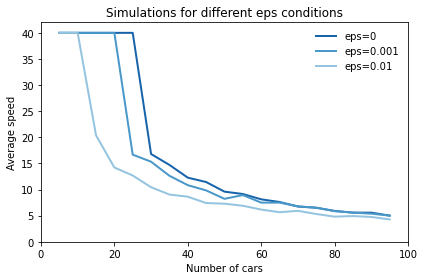

In [167]:
# Generate the figures for different eps conditions.
from utils import set_palette
set_palette('Blues', 4, reverse=True)

for eps in [0.0, 0.001, 0.01]:
    xs, ys = run_simulation(eps)
    plt.plot(xs, ys, label='eps=%g' % eps)
    
decorate(xlabel='Number of cars',
                 ylabel='Average speed',
                 title='Simulations for different eps conditions',
                 xlim=[0, 100], ylim=[0, 42])

## Assignment 

### Conceptual Option

Find three applications of agent-based simulations documented in the research literature relevant to your current job. Use Google Scholar (https://scholar.google.com/) and the McGill Library (https://www.mcgill.ca/library/) to find relevant sources. Read the abstracts and briefly describe the applications. Select one of the three applications and explore it in more detail. For the application you are analyzing in detail, answer the following questions:
- What are the assumptions or considerations of the simulation? 
- What are the simulation limitations? 
- What tool(s) did the researchers use to build the simulation?
- What is your opinion about the use of the selected application?

Reference the consulted sources using the APA format.

### Hands-on Option

The code section below creates three new classes and runs a loop to create a graph with the simulation results. The new classes `BetterDriver#` inherits from `Driver` and overrides `choose_acceleration`. The classes have the purpose of defining better driving rules than the basic implementation in `Driver` that only increases speed by 1 mile/hr as implemented in the code above. 

The loop runs simulations with `Driver` and the `BetterDriver#`, and plots average speed as a function of the number of cars. The plot uses the area under the curves as a way to quantify the effect of driving behaviour on average speed over a range of densities.

The method `choose_acceleration` receives the parameter `dist` that contains the distance to the next car and has access to the class attributes, like speed, via the variable `self.speed`. The minimum and maximum the acceleration are -10 miles/hr and 1 mile/hr, the maximum speed is 40 miles/hr, and the `eps` is 0.

For example, the provided `BetterDriverA` class is a little better in the sense that it keeps traffic moving smoothly at medium densities. However:
* At high densities, it has almost no effect, and

* At low densities, it is substantially worse.

As a result, the total area under the curve is smaller.

<b>Your objective is to design and code three `choose_acceleration` methods that try to maximize the area under the curve and analyze the simulation results.</b> Note that you won't be penalized if you can't find a way to maximize the area under the curve. Please submit your attempts and analysis.

In [172]:
class BetterDriver1(Driver):

    def choose_acceleration(self, dist):
        """
        Write your formulas and rules below.
        """
        if self.speed < 20:
            return 1
        else:
            return 0

In [173]:
class BetterDriver2(Driver):
    
    def choose_acceleration(self, dist):
        """
        Write your formulas and rules below.
        """
        return 0

In [174]:
class BetterDriver3(Driver):
    
    def choose_acceleration(self, dist):
        """
        Write your formulas and rules below.
        """
        return 0

Driver Total Area Under the Curve =  1512.925
BetterDriver1 Total Area Under the Curve =  1238.725
BetterDriver2 Total Area Under the Curve =  360.0
BetterDriver3 Total Area Under the Curve =  360.0


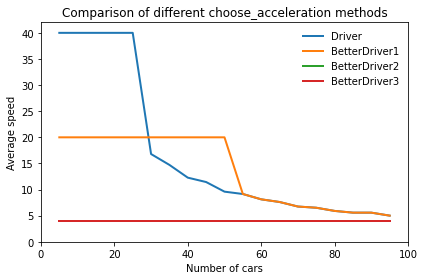

In [175]:
from scipy.integrate import trapezoid

for constructor in [Driver, BetterDriver1,BetterDriver2,BetterDriver3]:
    xs, ys = run_simulation(eps=0.0, constructor=constructor)
    plt.plot(xs, ys, label=constructor.__name__)
    print(constructor.__name__, 'Total Area Under the Curve = ' , trapezoid(ys, xs))
    
decorate(title='Comparison of different choose_acceleration methods',
    xlabel='Number of cars',
    ylabel='Average speed',
    xlim=[0, 100], ylim=[0, 42])

## Recommended Readings

Once you have completed the interaction portion of the module, please read the following recommended reading.

- Bernhardt, K., (2007). Agent-Based Modeling in Transportation. Transportation Research Circular, E-C113, 72-80. https://www.trb.org/Publications/Blurbs/158428.aspx

## Optional Readings

You will find additional resources in case you would like to continue exploring the topics covered in this module below.

- Chapter 10 - Herds, Flocks, and Traffic Jams. Downey, A. (2018). Think complexity: Complexity science and computational modeling (Second). O’Reilly Media. https://mcgill.on.worldcat.org/oclc/1043913738